In [1]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import os
from copy import deepcopy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from itertools import permutations
import torch.nn.functional as F
# from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import vector
from tqdm.notebook import tqdm


In [2]:
#load data
base_path = os.path.dirname(os.getcwd())

full_folder_path = os.path.join(base_path,"saved_files", "fake_data")
# data_df=pd.read_pickle(os.path.join(full_folder_path,"Aug7_1mil.pkl"))
# with open(os.path.join(full_folder_path,"Aug10_5mil.pkl"), 'rb') as f:
with open(os.path.join(full_folder_path,"Aug7_1mil.pkl"), 'rb') as f:
    clean_data_dict = pickle.load(f)
print(clean_data_dict.keys())
numevents=len(clean_data_dict['2_phi'])
print("number of events:",numevents)

data_dict=clean_data_dict
print(data_dict.keys())

data_dict_np={}
for key in data_dict.keys():
    data_dict_np[key]=np.array(data_dict[key])


# output features: deltaphi, deltaeta, deltaR, m_t,  norm_mt, mass, pt, eta , phi*(maybe dont use),  px, py, pz, energy


dict_keys(['event', 'genWeight', 'MET_phi', '1_phi', '1_genPartFlav', '2_phi', '2_genPartFlav', '3_phi', '3_genPartFlav', 'charge_1', 'charge_2', 'charge_3', 'pt_1', 'pt_2', 'pt_3', 'pt_MET', 'eta_1', 'eta_2', 'eta_3', 'mass_1', 'mass_2', 'mass_3', 'deltaphi_12', 'deltaphi_13', 'deltaphi_23', 'deltaphi_1MET', 'deltaphi_2MET', 'deltaphi_3MET', 'deltaphi_1(23)', 'deltaphi_2(13)', 'deltaphi_3(12)', 'deltaphi_MET(12)', 'deltaphi_MET(13)', 'deltaphi_MET(23)', 'deltaphi_1(2MET)', 'deltaphi_1(3MET)', 'deltaphi_2(1MET)', 'deltaphi_2(3MET)', 'deltaphi_3(1MET)', 'deltaphi_3(2MET)', 'deltaeta_12', 'deltaeta_13', 'deltaeta_23', 'deltaeta_1(23)', 'deltaeta_2(13)', 'deltaeta_3(12)', 'deltaR_12', 'deltaR_13', 'deltaR_23', 'deltaR_1(23)', 'deltaR_2(13)', 'deltaR_3(12)', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'mt_1MET', 'mt_2MET', 'mt_3MET', 'mt_1(23)', 'mt_2(13)', 'mt_3(12)', 'mt_MET(12)', 'mt_MET(13)', 'mt_MET(23)', 'mt_1(2MET)', 'mt_1(3MET)', 'mt_2(1MET)', 'mt_2(3MET)', 'mt_3(1MET)', 'mt_3(2MET)', 'ma

In [3]:
input_data_names_ordered = [
    ['MET_phi', 'pt_MET'], 
    ['1_phi', 'charge_1', 'pt_1', 'eta_1', 'mass_1'], 
    ['2_phi', 'charge_2', 'pt_2', 'eta_2', 'mass_2'], 
    ['3_phi', 'charge_3', 'pt_3', 'eta_3', 'mass_3']
]
input_data_particle_order = ['MET', '1', '2', '3']

pair_order = ["MET_1", "MET_2", "MET_3", "1_2", "1_3", "2_3"]
used_labels2 = [
    ['deltaphi_1MET', 'mt_1MET'], 
    ['deltaphi_2MET', 'mt_2MET'], 
    ['deltaphi_3MET', 'mt_3MET'], 
    ['deltaphi_12', 'deltaeta_12', 'deltaR_12', 'mt_12', 'norm_mt_12'], 
    ['deltaphi_13', 'deltaeta_13', 'deltaR_13', 'mt_13', 'norm_mt_13'], 
    ['deltaphi_23', 'deltaeta_23', 'deltaR_23', 'mt_23', 'norm_mt_23']
]

lepton_input_ordered = input_data_names_ordered[1:]
lepton_output_ordered = used_labels2[3:]

l_input_shape=(numevents,len(lepton_input_ordered), len(lepton_input_ordered[0]))
print("events, particles, input features: ",l_input_shape)
l_input= np.empty(l_input_shape)

for i in range(len(lepton_input_ordered)):
    for j, feature in enumerate(lepton_input_ordered[i]):
        l_input[:,i,j] = data_dict_np[feature]

l_output_shape=(numevents, len(lepton_output_ordered), len(lepton_output_ordered[0]))
print("events, particle pairs, output kin. features: ",l_output_shape)
l_output= np.empty(l_output_shape)

for i in range(len(lepton_output_ordered)):
    for j, feature in enumerate(lepton_output_ordered[i]):
        l_output[:,i,j] = data_dict_np[feature]

lepton_pair_order = pair_order[3:]
lepton_particle_order = input_data_particle_order[1:]
print("lepton pair order: ", lepton_pair_order)
print("lepton particle order: ", lepton_particle_order)

events, particles, input features:  (568554, 3, 5)
events, particle pairs, output kin. features:  (568554, 3, 5)
lepton pair order:  ['1_2', '1_3', '2_3']
lepton particle order:  ['1', '2', '3']


In [4]:
def add_extra_features(data):
    p1_pt=data['pt_1']
    p2_pt=data['pt_2']
    p3_pt=data['pt_3']

    p1_phi=data["1_phi"]
    p2_phi=data["2_phi"]
    p3_phi=data["3_phi"]

    p1_eta=data["eta_1"]
    p2_eta=data["eta_2"]
    p3_eta=data["eta_3"]

    p1_mass=data["mass_1"]
    p2_mass=data["mass_2"]
    p3_mass=data["mass_3"]

    particle1=vector.arr({"pt": p1_pt, "phi": p1_phi, "eta": p1_eta, "mass": p1_mass})
    particle2=vector.arr({"pt": p2_pt, "phi": p2_phi, "eta": p2_eta, "mass": p2_mass})
    particle3=vector.arr({"pt": p3_pt, "phi": p3_phi, "eta": p3_eta, "mass": p3_mass})

    p4_mother12=particle1+particle2
    p4_mother23=particle2+particle3
    p4_mother13=particle1+particle3

    pairs=['12','13','23']
    motherpairs=[p4_mother12, p4_mother13, p4_mother23]
    features_toadd=[ 'mass', 'pt', 'eta' , 'phi',  'px', 'py', 'pz', 'energy']
    # features_toadd=[ 'mass', 'pt', 'eta' , 'phi',  'px', 'py', 'pz']

    add_feat_size=(len(data['pt_1']), len(pairs), len(features_toadd))
    add_feat_array= np.empty(add_feat_size)

    for feature in features_toadd:
        for i, pair in enumerate(pairs):
           add_feat_array[:, i, features_toadd.index(feature)] = getattr(motherpairs[i], feature)
    return add_feat_array

    
    # for i, pair in enumerate(pairs):
    #     features_toadd=[ 'mass', 'pt', 'eta' , 'phi',  'px', 'py', 'pz', 'energy']
    #     for feature in features_toadd:
    #         data['mother_' + feature + '_' + pair] = motherpairs[i].feature
    # return data

data_conc=add_extra_features(data_dict_np)
print(data_conc.shape)
# print(data_new.columns)
l_output2= np.concatenate((l_output, data_conc), axis=2)
print("l_output new shape: ",l_output2.shape)


(568554, 3, 8)
l_output new shape:  (568554, 3, 13)


## normalizing ##

In [5]:
def normalize_l(data):
    # l_input_reshaped=l_input.reshape(l_input.shape[0], -1)
    # print("input reshaped shape:",l_input_reshaped.shape)
    # scaler = StandardScaler()
    # data_normalized = scaler.fit_transform(l_input_reshaped)

    means = data.mean(axis=(0))
    stds = data.std(axis=(0))
    # print("means shape:",means.shape)

    data_normalized = (data - means) / (stds + 1e-10)
    return data_normalized, means, stds

n_l_input, _, _ = normalize_l(l_input)
print("normalized input shape:",n_l_input.shape)


# n_l_output, l_output_means, l_output_stds = normalize_l(l_output2)
# print("normalized output shape:",n_l_output.shape)
n_l_output = l_output2

def invert_normalize(data_normalized, means, stds):
    return (data_normalized * stds) + means



normalized input shape: (568554, 3, 5)


In [6]:
print(n_l_output[:50,1,6])
pt_temp = n_l_output[:,1,6]
print("minimum, average, maximum of pt_temp: ", np.min(pt_temp), np.mean(pt_temp), np.max(pt_temp))
print("number of pt_temp <1: ", np.sum(pt_temp<1))

[127.65925444  50.38451351 105.9083741  143.78198014  50.2784581
  76.98569433  64.40583714  50.2685316   12.40852688  30.20481307
  43.1599017   74.24658947  31.10050124  11.69598121  34.31130309
  13.34241834  46.27893544 104.84989697  19.25859166  39.98089158
 198.70616154  89.2368842   60.7775276   15.65436875  47.6790552
  69.22424878  58.31752448  83.0497403   33.51982419  95.07007097
  20.81690484 139.14527975  60.95848307 101.93593479  48.29552732
 100.90652069 126.67423317  27.0692359   65.4648616  139.6482752
  61.58509847  25.52060152  97.41576292 112.02651407  96.74372081
  56.38019039  35.98896353  72.78795285 111.87488027  73.60917963]
minimum, average, maximum of pt_temp:  0.3126892113647423 83.50279435185988 527.6758410104538
number of pt_temp <1:  28


## Converting to tensor and adding pairs ##

In [7]:
linput_tensor = torch.tensor(n_l_input, dtype=torch.float32)
llabel_tensor = torch.tensor(n_l_output, dtype=torch.float32)

lpairs_data=[]
lpairs_labels=[]

# lepton_pair_order = ['1_2', '1_3', '2_3']
lepton_pair_mapping={(0,1): lepton_pair_order.index('1_2'), (0,2): lepton_pair_order.index('1_3'), (1,2): lepton_pair_order.index('2_3')}

for key, value in lepton_pair_mapping.items():
    concatonated_data=torch.cat((linput_tensor[:,key[0],:], linput_tensor[:,key[1],:]), dim=1)
    lpairs_data.append(concatonated_data)

    lpairs_labels.append(llabel_tensor[:,value,:])

print(len(lpairs_data), len(lpairs_labels))
print(lpairs_data[0].shape, lpairs_labels[0].shape)

3 3
torch.Size([568554, 10]) torch.Size([568554, 13])


## Making training data ##

In [8]:
train_data_list = []
val_data_list = []
test_data_list = []
train_labels_list = []
val_labels_list = []
test_labels_list = []

for pair_idx in range(len(lpairs_data)):
    pair_data = lpairs_data[pair_idx]
    pair_labels = lpairs_labels[pair_idx]

    train_val_data, test_data, train_val_labels, test_labels = train_test_split(pair_data, pair_labels, test_size=0.2, random_state=42)
    train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, test_size=0.2, random_state=42)

    train_data_list.append(train_data)
    val_data_list.append(val_data)
    test_data_list.append(test_data)
    train_labels_list.append(train_labels)
    val_labels_list.append(val_labels)
    test_labels_list.append(test_labels)

class ParticleDataset(Dataset):
    def __init__(self, data_list, labels_list):
        self.data_list = data_list
        self.labels_list = labels_list
    
    def __len__(self):
        return len(self.data_list[0])
    
    def __getitem__(self, idx):
        return [data[idx] for data in self.data_list], [label[idx] for label in self.labels_list]


## Defining Model ##

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


class CustomKinematicNet(nn.Module):
    def __init__(self, input_size, hidden_layers, lenoutput, activation_fn=F.relu, dropout_prob=0.2):
        """
        Args:
        - input_size (int): Size of the input layer.
        - hidden_layers (list of int): Sizes of each hidden layer.
        - lenoutput (int): Size of the output layer.
        - activation_fn (callable): Activation function to use.
        """
        super(CustomKinematicNet, self).__init__()
        
        # Create the list of layers
        layers = [nn.Linear(input_size, hidden_layers[0])]
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
        layers.append(nn.Linear(hidden_layers[-1], lenoutput))
        
        self.layers = nn.ModuleList(layers)
        self.activation_fn = activation_fn
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation_fn(layer(x))
            x = self.dropout(x)
        return self.layers[-1](x)

# hidden_layer_sizes = [128, 200, 300, 250, 128, 64]
lenoutput = l_output2.shape[2]
# model = CustomKinematicNet(input_size=10, hidden_layers=hidden_layer_sizes, lenoutput=lenoutput, activation_fn=F.relu)
# model.to(device)




cuda:0


## Training ##

In [12]:
def custom_loss(y_pred, y_true):
    # Compute MSE loss for each output individually
    mse_loss = F.mse_loss(y_pred, y_true, reduction='none')
    
    # Compute RMSE for specific indices and replace in the MSE loss
    indices = [3, 6, 12]
    for idx in indices:
        RMSE = torch.abs(y_pred[:, idx]**2 - y_true[:, idx]**2) / torch.abs(y_true[:, idx])
        mask = y_true[:, idx] > 1
        mse_loss[mask, idx] = RMSE[mask]
    
    # Calculate average loss of each output
    avg_loss_per_output = mse_loss.mean(dim=0)  # Averaging over the batch dimension
    
    # Normalize the average loss by its maximum loss value
    normalized_loss = avg_loss_per_output / avg_loss_per_output.max()
    
    # Calculate the total loss as the average of the normalized losses
    total_loss = normalized_loss.mean()
    
    return total_loss

def train_one_epoch(model, data_loader, optimizer, device):
    model.train()
    total_train_loss = 0
    
    for data, labels in data_loader:
        data = [d.to(device) for d in data]
        labels = [l.to(device) for l in labels]
        
        optimizer.zero_grad()
        total_loss = 0
        for i in range(len(data)):
            y_pred = model(data[i])
            # loss = loss_fn(y_pred, labels[i])
            loss = custom_loss(y_pred, labels[i])
            total_loss += loss
        total_train_loss += total_loss.item()
        
        total_loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(data_loader)
    return avg_train_loss

# def train_one_epoch(model, data_loader, optimizer, device):
#     model.train()
#     total_train_loss=0
    
#     for data, labels in data_loader:
#         data = [d.to(device) for d in data]
#         labels = [l.to(device) for l in labels]
        
#         optimizer.zero_grad()
#         total_loss = 0
#         for i in range(len(data)):
#             y_pred = model(data[i])
#             total_loss = custom_loss(y_pred, labels[i])
            
#             total_batch_loss += curr_loss

        
#         total_batch_loss.backward()
#         optimizer.step()


# def validate_one_epoch(model, data_loader, device):
#     model.eval()
#     total_mse_loss = 0
#     total_rr_loss = 0
    
#     with torch.no_grad():
#         for data, labels in data_loader:
#             data = [d.to(device) for d in data]
#             labels = [l.to(device) for l in labels]
            
#             total_loss = 0
#             for i in range(len(data)):
#                 y_pred = model(data[i])
#                 mse, rr = custom_loss(y_pred, labels[i])
                
#                 total_mse_loss += mse.item()
#                 total_rr_loss += rr.item()

#     avg_mse_loss = total_mse_loss / len(data_loader)
#     avg_rr_loss = total_rr_loss / len(data_loader)
#     return avg_mse_loss, avg_rr_loss

def validate_model(model, data_loader, device):
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for data, labels in data_loader:
            data = [d.to(device) for d in data]
            labels = [l.to(device) for l in labels]

            total_loss = 0
            for i in range(len(data)):
                y_pred = model(data[i])
                # loss = loss_fn(y_pred, labels[i])
                loss = custom_loss(y_pred, labels[i])                
                total_loss += loss
            total_val_loss += total_loss.item()

    avg_val_loss = total_val_loss / len(data_loader)
    return avg_val_loss

# def test_model2(model, data_loader, device):
#     model.eval()
#     total_mse_loss = 0
#     total_rr_loss = 0

#     with torch.no_grad():
#         for data, labels in data_loader:
#             data = [d.to(device) for d in data]
#             labels = [l.to(device) for l in labels]

#             total_loss = 0
#             for i in range(len(data)):
#                 y_pred = model(data[i])
#                 mse, rr = custom_loss(y_pred, labels[i])

#                 total_mse_loss += mse.item()
#                 total_rr_loss += rr.item()
#     avg_mse_loss = total_mse_loss / len(data_loader)
#     avg_rr_loss = total_rr_loss / len(data_loader)
#     return avg_mse_loss, avg_rr_loss


def test_model(model, data_loader, device):
    model.eval()
    total_test_loss = 0

    with torch.no_grad():
        for data, labels in data_loader:
            data = [d.to(device) for d in data]
            labels = [l.to(device) for l in labels]

            total_loss = 0
            for i in range(len(data)):
                y_pred = model(data[i])
                # loss = loss_fn(y_pred, labels[i])
                loss = custom_loss(y_pred, labels[i])
                total_loss += loss
            total_test_loss += total_loss.item()

    avg_test_loss = total_test_loss / len(data_loader)
    return avg_test_loss

def main_training_loop(model, num_epochs, train_data_list, train_labels_list, val_data_list, val_labels_list, optimizer, loss_fn, device, early_stop_patience, batch_size=320):
    epochs_no_improve = 0
    min_val_loss = np.Inf


    train_dataset = ParticleDataset(train_data_list, train_labels_list)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = ParticleDataset(val_data_list, val_labels_list)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = ParticleDataset(test_data_list, test_labels_list)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        test_loss = train_one_epoch(model, train_loader, optimizer, device)
        # model, data_loader, optimizer, device
        # train_loss = train_one_epoch(model, train_data_list, train_labels_list, optimizer, loss_fn, device)
        val_loss = validate_model(model, val_loader, device)
        # val_loss = validate_model(model, val_loader, loss_fn, device)
        # val_loss = validate_model(model, val_data_list, val_labels_list, loss_fn, device)
        
        if val_loss < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = val_loss
            saved_model = model.state_dict()
            # torch.save(model.state_dict(), 'fnn_FeatureRegression/fnn_try4.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stop_patience:
                print('Early stopping!')
                return saved_model
        if (epoch +1) % 5 == 0:
            # test_loss = test_model(model, test_data_list, test_labels_list, loss_fn, device)
            # test_loss = test_model(model, test_loader, loss_fn, device)
            test_loss = test_model(model, test_loader, device)
            print(f"Epoch [{epoch + 1}], "
            f"Train Loss: ({test_loss*1000:.4f}), "
                f"Val Loss: ({val_loss*1000:.4f}), "
                f"Test Loss: ({test_loss:.4f})")
        
        else:
            print(f"Epoch [{epoch + 1}], "
                f"Train Loss: ({test_loss*1000:.4f}), "
                f"Val Loss: ({val_loss*1000:.4f})")

In [13]:
batch_size=1000
num_epochs = 100000
early_stop_patience = 15
loss_fn = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

saved_models = []
# hidden_layers_list= [[128, 200, 300, 250, 128, 64], 
#                      [32,42,52,64,74,52,42,32,16], 
#                      [32,42,52,64,42,32], 
#                      [32,42,52,64,42,16], 
#                      [32,32,32,32,32,32,32,32,32,32], 
#                      [32,32,32,32,32,32], 
#                      [32,32,32]]
# hidden_layers_list= [[128, 200, 300, 250, 128, 64]]
# hidden_layers_list= [[32,42,52,64,74,52,42,32,32]]
# hidden_layers_list= [[32,42,52,64,74,82,74,64,64,50]]
hidden_layers_list= [[32,32,32,32,32,32,32,32,32,32,32,32,32]]

pbar = tqdm(hidden_layers_list, total=len(hidden_layers_list))

for i, hidden_layers_curr in enumerate(pbar):
    pbar.set_description(f"model [{i+1}/{len(hidden_layers_list)}]")
    # print(f"[{i+1}/{len(hidden_layers_list)}] Hidden Layers: {hidden_layers_curr}")
    curr_model= CustomKinematicNet(input_size=10, hidden_layers=hidden_layers_curr, lenoutput=lenoutput, activation_fn=F.sigmoid)
    curr_model.to(device)
    optimizer = torch.optim.Adam(curr_model.parameters(), lr=0.001)
    curr_saved_model = main_training_loop(curr_model, num_epochs, train_data_list, train_labels_list, val_data_list, val_labels_list, optimizer, loss_fn, device, early_stop_patience, batch_size=batch_size)
    saved_models.append(curr_saved_model)



# Format: (MSE, RMSE)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1], Train Loss: (0.3471), Val Loss: (0.3419
Epoch [2], Train Loss: (0.3375), Val Loss: (0.3327
Epoch [3], Train Loss: (0.3283), Val Loss: (0.3236
Epoch [4], Train Loss: (0.3195), Val Loss: (0.3151
Epoch [5], Train Loss: (0.3076), Val Loss: (0.3078Test Loss: (0.3076
Epoch [6], Train Loss: (0.3048), Val Loss: (0.3015
Epoch [7], Train Loss: (0.2989), Val Loss: (0.2960
Epoch [8], Train Loss: (0.2939), Val Loss: (0.2914
Epoch [9], Train Loss: (0.2896), Val Loss: (0.2873
Epoch [10], Train Loss: (0.2838), Val Loss: (0.2839Test Loss: (0.2838
Epoch [11], Train Loss: (0.2826), Val Loss: (0.2809
Epoch [12], Train Loss: (0.2798), Val Loss: (0.2782
Epoch [13], Train Loss: (0.2773), Val Loss: (0.2759
Epoch [14], Train Loss: (0.2750), Val Loss: (0.2737
Epoch [15], Train Loss: (0.2718), Val Loss: (0.2718Test Loss: (0.2718
Epoch [16], Train Loss: (0.2711), Val Loss: (0.2700
Epoch [17], Train Loss: (0.2694), Val Loss: (0.2683
Epoch [18], Train Loss: (0.2677), Val Loss: (0.2667
Epoch [19], Train L

In [ ]:
losses_dict = {}
for i, hidden_layer in enumerate(hidden_layers_list):
    saved_model = CustomKinematicNet(input_size=10, hidden_layers=hidden_layer, lenoutput=lenoutput, activation_fn=F.relu)
    saved_model.load_state_dict(saved_models[i])
    saved_model.to(device)

    test_dataset = ParticleDataset(test_data_list, test_labels_list)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)
    test_loss = test_model(saved_model, test_loader, loss_fn, device)
    # test_loss = test_model(saved_model, test_data_list, test_labels_list, loss_fn, device)
    losses_dict[str(hidden_layer)] = (i,test_loss)

sorted_losses_dict = dict(sorted(losses_dict.items(), key=lambda item: item[1][1], reverse=False))

for key, value in sorted_losses_dict.items():
    print(f"{key}: {value}")


[32, 42, 52, 64, 74, 82, 74, 64, 64, 50]: (0, 1075.3932218802602)


## Plotting Histogram ##

plot_hidden_layer sizes [32, 42, 52, 64, 74, 82, 74, 64, 64, 50]


Testing:   0%|          | 0/3 [00:00<?, ?it/s]

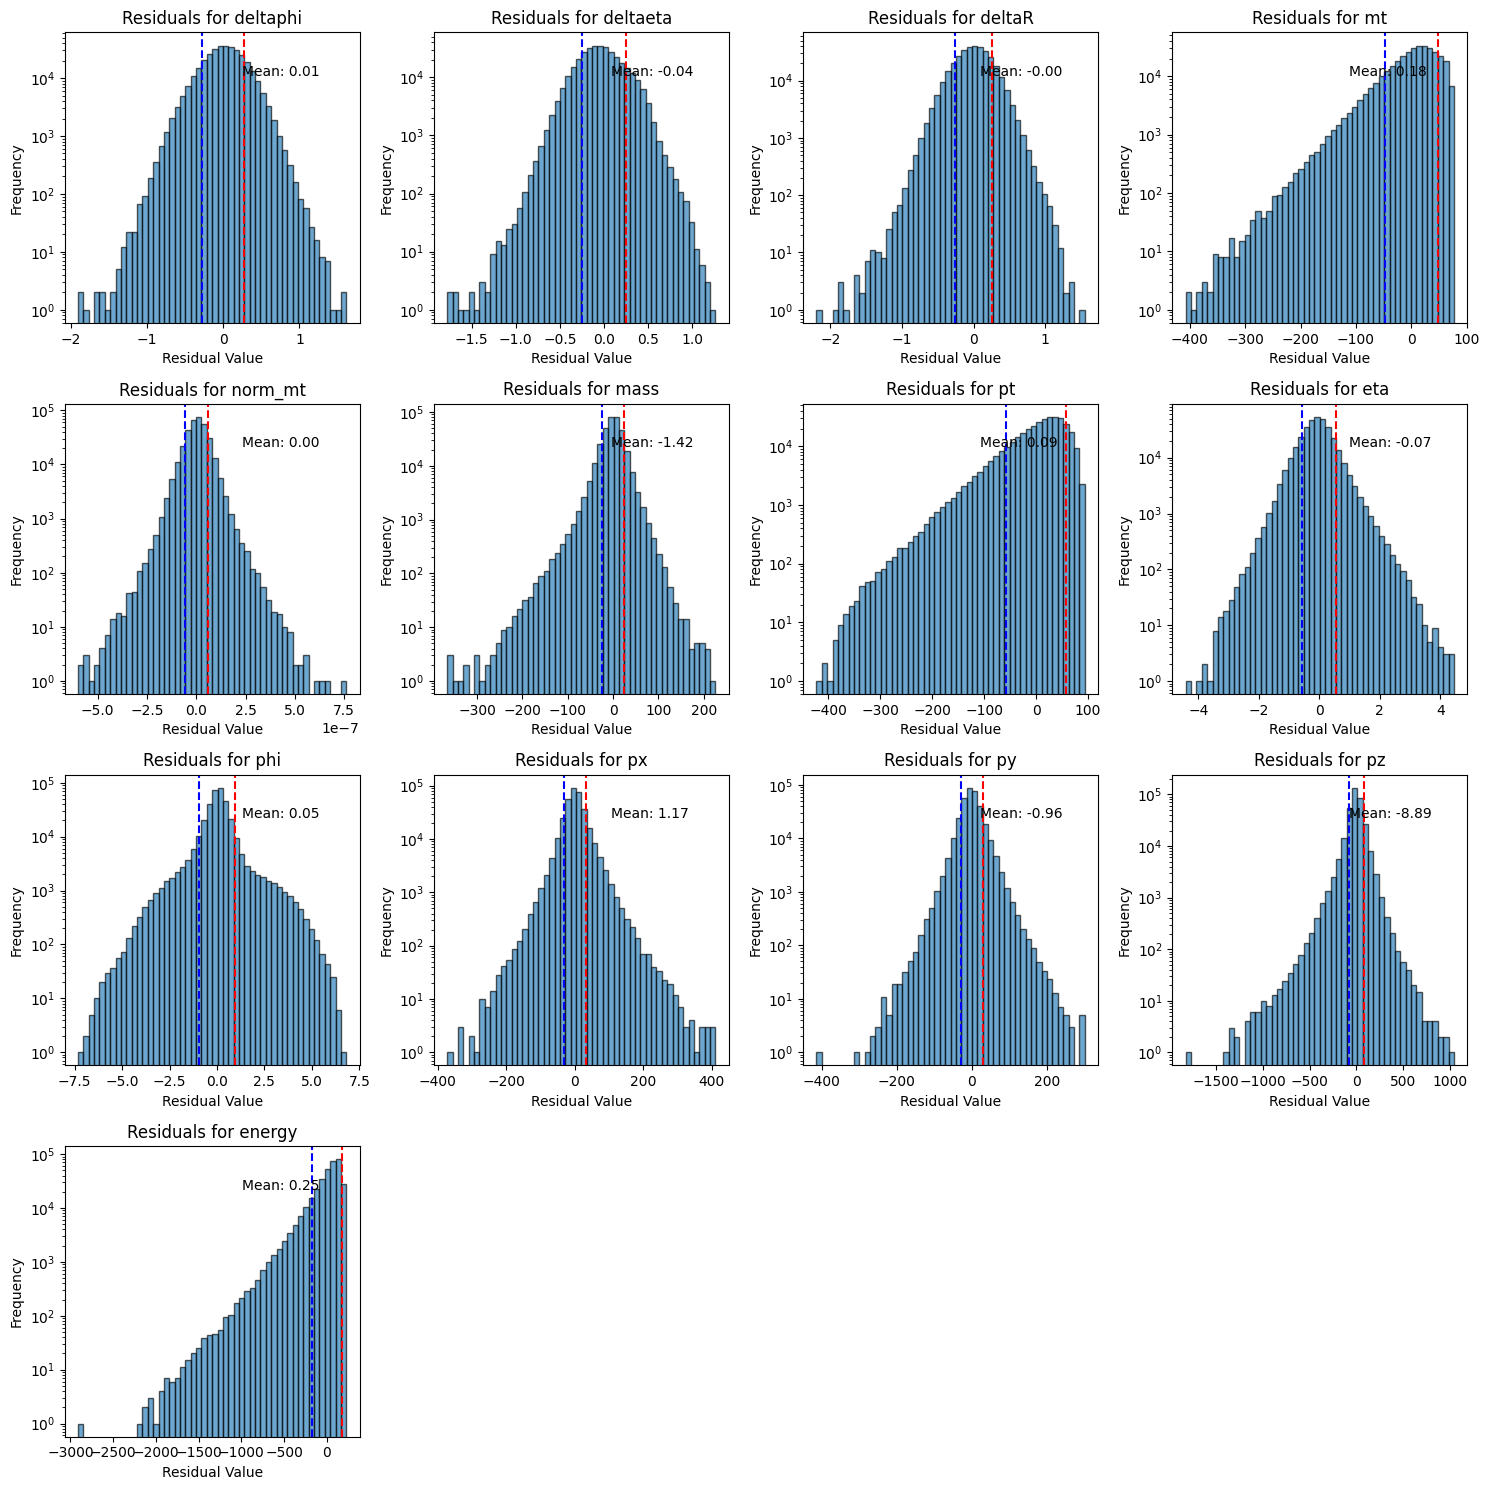

In [ ]:
# saved_model = KinematicNet(lenoutput)
model_loc=0
plot_hidden_layer = hidden_layers_list[model_loc]
print('plot_hidden_layer sizes', plot_hidden_layer)
saved_model = CustomKinematicNet(input_size=10, hidden_layers=plot_hidden_layer, lenoutput=lenoutput, activation_fn=F.relu)
saved_model.load_state_dict(saved_models[model_loc])
saved_model.to(device)
saved_model.eval()
# ['deltaphi_12', 'deltaeta_12', 'deltaR_12', 'mt_12', 'norm_mt_12']
out_feats=['deltaphi', 'deltaeta', 'deltaR', 'mt', 'norm_mt', 'mass', 'pt', 'eta' , 'phi',  'px', 'py', 'pz', 'energy']
num_features = n_l_output.shape[2]
residuals = [[] for _ in range(num_features)]
label_values = [[] for _ in range(num_features)]



with torch.no_grad():
    for pair_idx in tqdm(range(len(test_data_list)), desc='Testing', leave=False):
        test_data = test_data_list[pair_idx].to(device)
        test_label = test_labels_list[pair_idx].numpy()  # Convert tensor to numpy
        
        y_pred = saved_model(test_data).cpu().numpy()  # Convert tensor to numpy
        # y_pred_inverted = invert_normalize(y_pred, l_output_means[pair_idx, :], l_output_stds[pair_idx, :])
        # test_label_inverted = invert_normalize(test_label, l_output_means[pair_idx, :], l_output_stds[pair_idx, :])
        
        # residuals_pair = y_pred_inverted - test_label_inverted
        residuals_pair = y_pred - test_label
        
        for i in range(num_features):
            residuals[i].extend(residuals_pair[:, i])
            # label_values[i].extend(test_label_inverted[:, i])
            label_values[i].extend(test_label[:, i])


residuals = [np.array(res_list) for res_list in residuals]  # Convert lists of arrays to arrays
# residual_medians = [np.median(res) for res in residuals]
residual_std_devs = [np.std(res) for res in residuals]
residual_means = [np.mean(res) for res in residuals]


# print('std_devs length', len(std_devs))

num_rows = 4
num_cols = 4


fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))
flat_axes = axes.flatten()

for i, ax in enumerate(flat_axes[:num_features]):
    ax.hist(residuals[i], bins=50, edgecolor='k', alpha=0.65)
    ax.axvline(x=residual_means[i] + residual_std_devs[i], color='r', linestyle='--', label=f'+1 std from mean (value: {residual_means[i] + residual_std_devs[i]:.2f})')
    ax.axvline(x=residual_means[i] - residual_std_devs[i], color='b', linestyle='--', label=f'-1 std from mean (value: {residual_means[i] - residual_std_devs[i]:.2f})')
    ax.set_title(f'Residuals for {out_feats[i]}')
    ax.set_yscale('log')
    ax.set_xlabel('Residual Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    
    # Display the mean value on the plot
    mean_text = f"Mean: {residual_means[i]:.2f}"
    ax.text(0.6, 0.85, mean_text, transform=ax.transAxes)
    

for ax in flat_axes[num_features:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# save_path=os.path.join(base_path, 'saved_files', 'saved_models', 'FNN_FeatureRegression', 'aug11_customloss_1.pt')
# torch.save(saved_model.state_dict(), save_path)

bin errors for feature pt [36.76506271  5.96059991  0.93764636  0.04855776]
bin errors for feature mt [1.18836591e+02 1.06954276e+01 8.02872447e-01 3.75582909e-02]
bin errors for feature energy [       nan        nan 0.79074707 0.23529987]


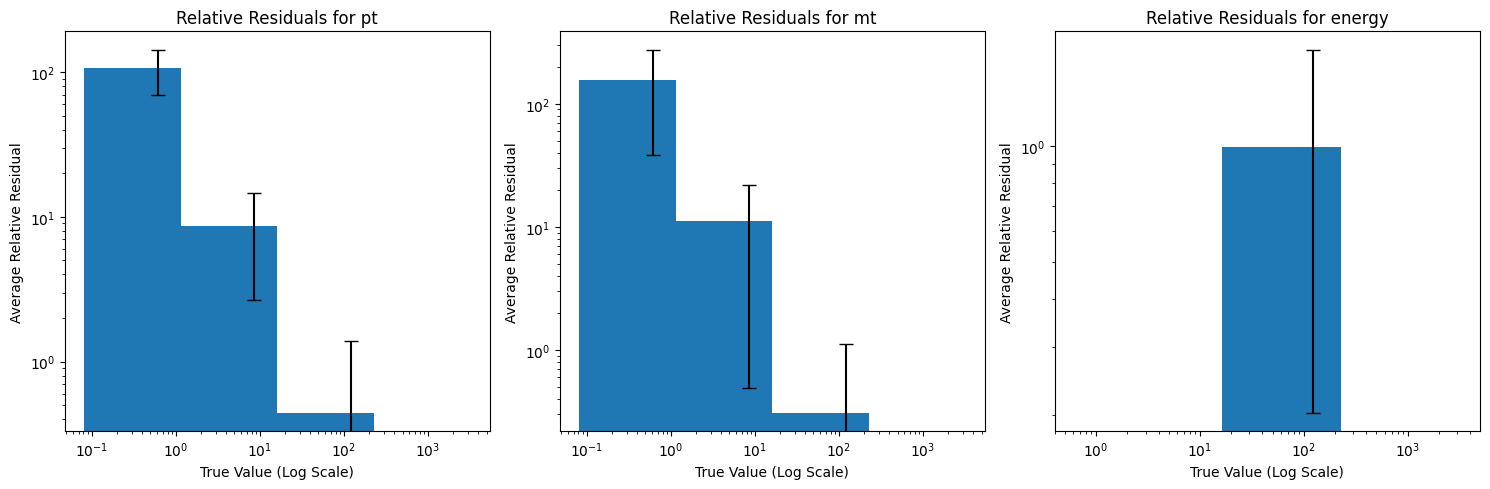

In [ ]:
from scipy import stats


selected_features = ['pt', 'mt', 'energy']
selected_indices = [out_feats.index(feat) for feat in selected_features]

# Calculate relative residuals
relative_residuals = [residuals[i] / label_values[i] for i in selected_indices]

# Define logarithmic bins
bins = np.logspace(np.log10(min([min(label_values[i]) for i in selected_indices])),
                   np.log10(max([max(label_values[i]) for i in selected_indices])),
                   num=5)  # 10 bins as an example, adjust as needed

fig, axes = plt.subplots(nrows=1, ncols=len(selected_features), figsize=(15, 5))

for idx, ax in enumerate(axes):
    feature_index = selected_indices[idx]
    # print(relative_residuals[idx])
    # Compute binned statistics (mean and std)
    bin_means, bin_edges, binnumber = stats.binned_statistic(label_values[feature_index],
                                                             relative_residuals[idx],
                                                             statistic='mean',
                                                             bins=bins)
    
    bin_stds, _, _ = stats.binned_statistic(label_values[feature_index],
                                            relative_residuals[idx],
                                            statistic='std',
                                            bins=bins)

    # Compute the widths of the bars
    bar_widths = np.diff(bin_edges)

    print("bin errors for feature", selected_features[idx], bin_stds)
    # Plot the bar plot with error bars
    ax.bar(x=bin_edges[:-1], height=bin_means, width=bar_widths, align='edge', yerr=bin_stds, capsize=5)
    # ax.bar(x=bin_edges[:-1], height=bin_means, width=bar_widths, align='edge', yerr=None, capsize=5)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Relative Residuals for {selected_features[idx]}')
    ax.set_xlabel('True Value (Log Scale)')
    ax.set_ylabel('Average Relative Residual')
    # break

plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import anderson

ad_results = []
for i, feature_name in enumerate(out_feats):
    result = anderson(residuals[i])
    ad_results.append({
        'feature': feature_name,
        'statistic': result.statistic,
        'critical_values': result.critical_values,
        'significance_levels': result.significance_level,
        'result': 'Normal' if result.statistic < result.critical_values[2] else 'Not Normal'  # Using 5% significance level
    })
for result in ad_results:
    print('Feature: %s' % result['feature'])
    print('Statistic: %.3f' % result['statistic'])
    for sl, cv in zip(result['significance_levels'], result['critical_values']):
        print('Significance level: %.3f, Critical value: %.3f' % (sl, cv))
    print('Result: %s' % result['result'])
    print()

Feature: deltaphi
Statistic: 142.894
Significance level: 15.000, Critical value: 0.576
Significance level: 10.000, Critical value: 0.656
Significance level: 5.000, Critical value: 0.787
Significance level: 2.500, Critical value: 0.918
Significance level: 1.000, Critical value: 1.092
Result: Not Normal

Feature: deltaeta
Statistic: 256.828
Significance level: 15.000, Critical value: 0.576
Significance level: 10.000, Critical value: 0.656
Significance level: 5.000, Critical value: 0.787
Significance level: 2.500, Critical value: 0.918
Significance level: 1.000, Critical value: 1.092
Result: Not Normal

Feature: deltaR
Statistic: 114.111
Significance level: 15.000, Critical value: 0.576
Significance level: 10.000, Critical value: 0.656
Significance level: 5.000, Critical value: 0.787
Significance level: 2.500, Critical value: 0.918
Significance level: 1.000, Critical value: 1.092
Result: Not Normal

Feature: mt
Statistic: 5206.320
Significance level: 15.000, Critical value: 0.576
Signific

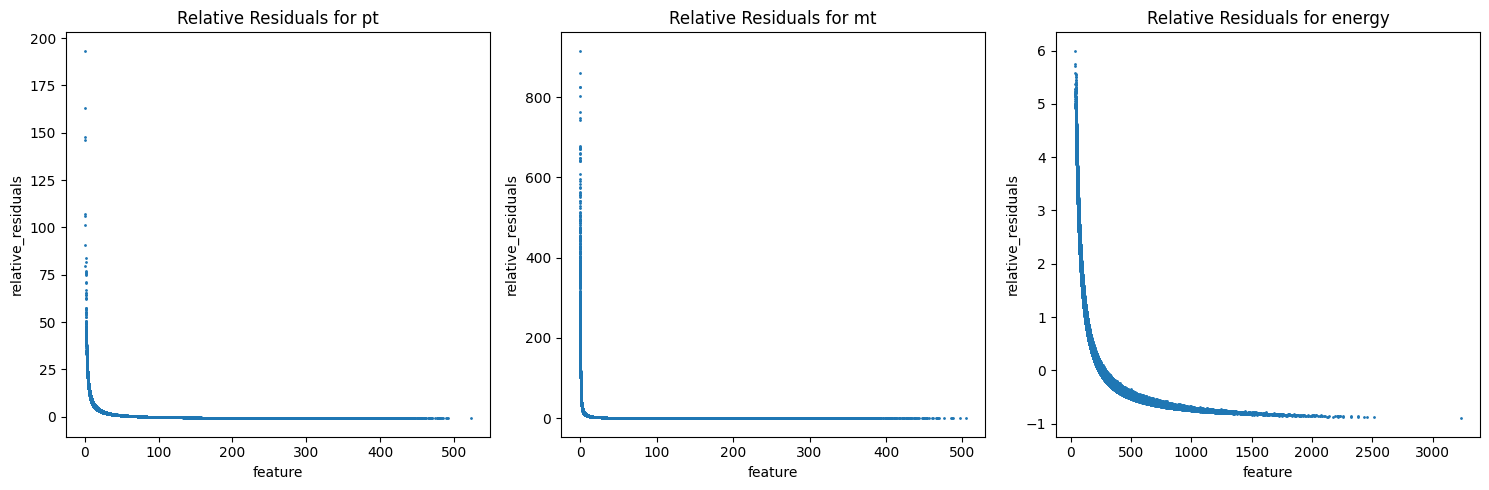

In [ ]:
selected_features = ['pt', 'mt', 'energy']
selected_indices = [out_feats.index(feat) for feat in selected_features]

# Calculate relative residuals
relative_residuals = [residuals[i] / label_values[i] for i in selected_indices]

# Plot the histograms
fig, axes = plt.subplots(nrows=1, ncols=len(selected_features), figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.scatter(label_values[selected_indices[i]], relative_residuals[i], s=1)
    ax.set_title(f'Relative Residuals for {selected_features[i]}')
    ax.set_xlabel('feature')
    ax.set_ylabel('relative_residuals')

plt.tight_layout()
plt.show()
